### Load data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv")

In [2]:
data['Date'] = pd.to_datetime(data['Date'])

#### Split train, test period

In [3]:
# Split data into 2 periods
start_day_p1 = pd.Timestamp(2015, 8, 7)
test_day_p1 = pd.Timestamp(2018, 4, 1)
end_day_p1 = pd.Timestamp(2018, 9, 30)

period1 = data[(data["Date"] >= start_day_p1) & (data["Date"] <= end_day_p1) ].reset_index(drop = True)
train_dataset_p1 = period1[period1["Date"] < test_day_p1].reset_index(drop = True)
test_dataset_p1 = period1[period1["Date"] >= test_day_p1].reset_index(drop = True)


start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] >= start_day_p2) & (data["Date"] <= end_day_p2) ].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)

train_dataset_p1 = train_dataset_p1.drop("Date", axis=1)
test_dataset_p1 = test_dataset_p1.drop("Date", axis=1)
train_dataset_p2 = train_dataset_p2.drop("Date", axis=1)
test_dataset_p2 = test_dataset_p2.drop("Date", axis=1)


print(period1.shape, period2.shape)

(1151, 48) (1279, 48)


### List Evaluation metrics

In [4]:
# Metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

### Function to create X and y

In [5]:
# Function to create X and y
def create_train_test(train_dataset, test_dataset):
	X_train = train_dataset[:-1]
	Y_train = train_dataset["BTC_Close"][1:]
	X_test = test_dataset[:-1]
	Y_test = test_dataset["BTC_Close"][1:]
	return X_train, Y_train, X_test, Y_test

X_train_p1, Y_train_p1, X_test_p1, Y_test_p1 = create_train_test(train_dataset_p1, test_dataset_p1)
X_train_p2, Y_train_p2, X_test_p2, Y_test_p2 = create_train_test(train_dataset_p2, test_dataset_p2)
# Count Nan values
print(f"NaN values in X_train_p2: {X_train_p2.isnull().sum()}")
print(f"NaN values in Y_train_p2: {Y_train_p2.isnull().sum()}")

NaN values in X_train_p2: BTC_Open                       0
BTC_High                       0
BTC_Low                        0
BTC_Close                      0
BTC_Volume                     0
Active Addr Cnt                0
Xfer Cnt                       0
Mean Tx Size (native units)    0
Total Fees (USD)               0
Mean Hash Rate                 0
Difficulty                     0
Mean Block Size (in bytes)     0
Sum Block Weight               0
LTC                            0
XRP                            0
DASH                           0
DOGE                           0
ETH                            0
Gold                           0
Silver                         0
Copper                         0
Oil                            0
Treasury Yield 10 Years        0
S&P500                         0
DJI                            0
CBOE                           0
NASDAQ                         0
JP225                          0
CSI300                         0
DXY              

#### Min-max scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_p2 = scaler.fit_transform(X_train_p2)
X_test_p2 = scaler.transform(X_test_p2)

### Create model

#### Create ParamGrid

In [7]:
from sklearn.model_selection import ParameterGrid

params = {
    'hidden_layer_sizes': [(64, 128, 64), (64, 64, 64), (128, 128, 128), (128, 256, 128), (128, 256, 256, 128)],
    'activation': ['relu'],
}

param_grid = list(ParameterGrid(params))
print(len(param_grid))
print(param_grid[0])

5
{'activation': 'relu', 'hidden_layer_sizes': (64, 128, 64)}


In [8]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(random_state=0, max_iter=3000)

In [9]:
import gc
final_model = None
best_score = 1000000000

for param in param_grid:
    model.set_params(**param)
    model.fit(X_train_p2, Y_train_p2)
    Y_pred = model.predict(X_test_p2)
    score = root_mean_squared_error(Y_test_p2, Y_pred)
    if score < best_score:
        best_score = score
        final_model = model
        best_param = param
    gc.collect()
    print(param, score)

{'activation': 'relu', 'hidden_layer_sizes': (64, 128, 64)} 2843.285600326055
{'activation': 'relu', 'hidden_layer_sizes': (64, 64, 64)} 2983.130114898289
{'activation': 'relu', 'hidden_layer_sizes': (128, 128, 128)} 2932.804112196216
{'activation': 'relu', 'hidden_layer_sizes': (128, 256, 128)} 2743.4880410305504
{'activation': 'relu', 'hidden_layer_sizes': (128, 256, 256, 128)} 2627.5500543044145


{'activation': 'relu', 'hidden_layer_sizes': (128, 256, 256, 128)} 2627.5500543044145
R2 score:  0.9106139621396615
directional_accuracy:  49.171270718232044


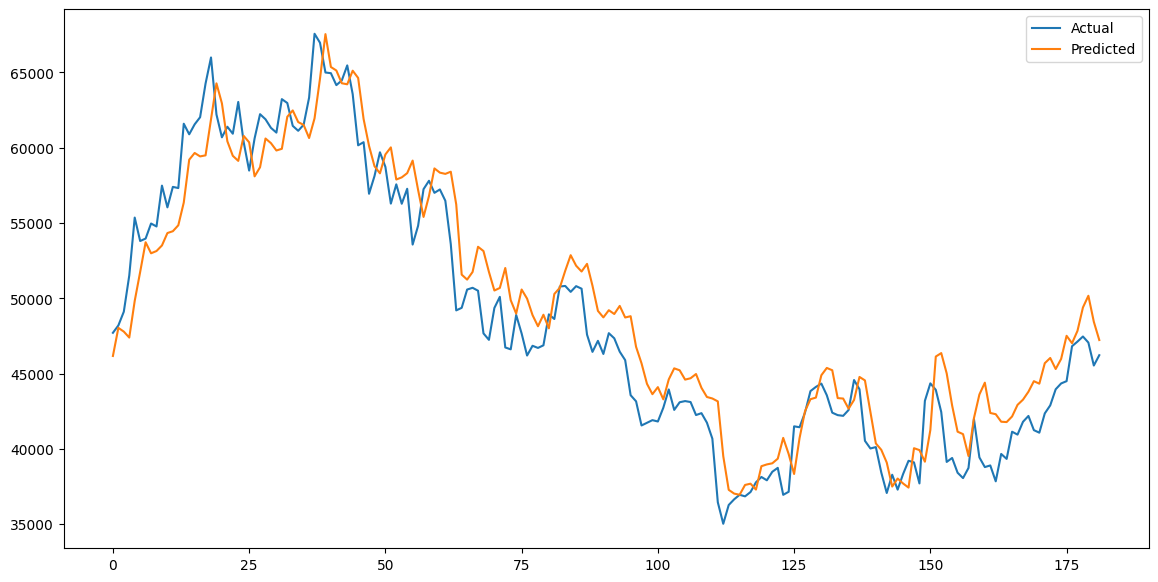

In [10]:
print(best_param, best_score)
# plot prediction
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

Y_pred = final_model.predict(X_test_p2)
print("R2 score: ", r2_score(Y_test_p2, Y_pred))
print("directional_accuracy: ", directional_accuracy(Y_test_p2, Y_pred))

plt.plot(Y_test_p2.values, label="Actual")
plt.plot(Y_pred, label="Predicted")
plt.legend()
plt.show()


In [11]:
import pickle
import os
file_name = "/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/implementations/models/mlp_p2.pkl"
if not os.path.exists(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
pickle.dump(final_model, open(file_name, "wb"))